In [1]:
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Nadam
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import random
import numpy
from tensorflow.compat.v1.random import set_random_seed

random.seed(1)
numpy.random.seed(1)
set_random_seed(2)

In [3]:
def mse(predictions, targets):
        return ((predictions - targets) ** 2).mean()

In [4]:
import tensorflow as tf
def mse_tf(predictions, targets):
        return tf.reduce_mean((predictions - targets) ** 2)

In [5]:
def readDataset(filename):
    text_file = open(filename, 'r')
    dataset = []   
    for line in text_file:  
        line = line.split(',')      
        dt = [ float(x) for x in line ]
        dataset.append(dt)    
    text_file.close()
    dataset = np.array(dataset)
    return dataset

In [6]:
def tagData(data, perc):
    sz  = math.ceil(data.shape[0]*perc/100)
    dat = np.zeros((data.shape[0],data.shape[1]*2))
    dat[:data.shape[0],: data.shape[1]] =data  #append column for labels
    dat[:data.shape[0]-1,data.shape[1]:] =data[1:,:]  #append column for labels
    xtrain = dat[:sz,:4]    
    ytrain = dat[:sz,4:]
    xtest  = dat[sz-1:,:4]
    ytest  = dat[sz-1:, 4:]
    xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
    xtest  = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
    return xtrain, ytrain, xtest, ytest

In [7]:
percentage = 60

In [8]:
file = '../Data/EURUSDmicro_ H4_CandleData.txt'
data = readDataset(file)

xtrain, ytrain, xtest, ytest = tagData(data,percentage)
print('training samples: ', xtrain.shape)
print('testing samples: ', xtest.shape)

training samples:  (6047, 1, 4)
testing samples:  (4031, 1, 4)


In [9]:
xtrain2, ytrain2, xtest2, ytest2 = xtrain.reshape(len(xtrain), 4), ytrain.reshape(len(ytrain), 4), xtest.reshape(len(xtest), 4), ytest.reshape(len(ytest), 4)

opt = Nadam(lr=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=None, schedule_decay=0.0004)
cand = Sequential()
cand.add(Dense(50))
cand.add(Dense(4))
cand.compile(loss=mse_tf, optimizer=opt)#'Nadam'
start =  time.time()
cand_history = cand.fit(xtrain2, ytrain2, epochs=150, batch_size=64, validation_data=(xtest2, ytest2), verbose=0, shuffle=True)
end =  time.time()
print("time of execution = ", end-start, "seconds")
y_pred = cand.predict(xtest2)
print("MSE Open:",  mse(y_pred[:,0], ytest[:,0]))
print("MSE High:",  mse(y_pred[:,1], ytest[:,1]))
print("MSE Low:",   mse(y_pred[:,2], ytest[:,2]))
print("MSE Close:", mse(y_pred[:,3], ytest[:,3]))

time of execution =  31.329946756362915 seconds
MSE Open: 0.00035825277495305885
MSE High: 0.00035657274874107293
MSE Low: 0.0003446439657763231
MSE Close: 0.0003505747062968222


In [10]:
class Models():
    def __init__(self, activations):
        self.activations = activations
        self.history_dictionary = {}
        self.opt = Nadam(lr=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=None, schedule_decay=0.0004)
        self.predictions = {}
        
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    def mse(self, predictions, targets):
        return ((predictions - targets) ** 2).mean()
    
    def train_all(self, xtrain, ytrain, epochs = 20, verbose=0):
        
        for i, act in enumerate(self.activations):
            start =  time.time()
            cand = Sequential()
            cand.add(LSTM(200, input_shape=(xtrain.shape[1], xtrain.shape[2]), activation=act))
            cand.add(Dense(4))
            cand.compile(loss='mean_squared_error', optimizer=self.opt)#'Nadam'
            cand_history = cand.fit(xtrain, ytrain, epochs=epochs, batch_size=72, validation_data=(xtest, ytest), verbose=verbose, shuffle=False)
            self.history_dictionary[act] = (cand_history, cand)
            print("done training model with activation", act, "  ", i+1,"/", len(self.activations), "completed.")
            end =  time.time()
            print("time of execution = ", end-start, "seconds")
    
    def plot_validation_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history = pair[0]
            plt.plot(cand_history.history['val_loss'], label=label)
            plt.title('Candle validation loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
    
    def plot_train_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history =pair[0]
            plt.plot(cand_history.history['loss'], label= label)
            plt.title('Candle training loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, xtest):
        print('predicting candles and evaluating models...')
        mapp = {"Open": 0, "High":1, "Low":2, "Close":3}
        groups = {"Open": [], "High":[], "Low": [], "Close": []}
        for label, pair in self.history_dictionary.items():
            model =pair[1]
            prediCand = model.predict(xtest)
            self.predictions[label] = prediCand
            for name, id_ in mapp.items():
                pred = prediCand[:,id_]
                act = ytest[:,id_]
                mean_sq_err = self.mse(act, pred)
                print(label, ": ", name, " MSE =>\t", mean_sq_err)
                groups[name].append(mean_sq_err)
            print(".................................................")
        return groups
            
    def plot(self, name="Open"):
        mapp = {"Open": 0, "open":0,  "High":1, "high":1 ,   "Low":2, "low":2 , "Close":3, "close":3 }
        plt.figure(figsize=(8,5))
        id_ = mapp[name]
        act = ytest[:,id_]
        label_2 = 'actual '+ name + ' price'
        plt.plot(act[:len(act)-1],     label = label_2)
        for label, prediCand in self.predictions.items():
            pred = prediCand[:, id_]
            label_1 = label+ ': Predicted '+ name + ' price'
            plt.plot(pred[:len(pred)-1],   label = label_1);
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title('EUR/USD '+ name +' price')
            plt.grid(True)
            plt.legend(loc = 'best')
        plt.show()
        
    def plot_error(self, dictionary, n):
        # set width of bar
        barWidth = 0.12
        # Set position of bar on X axis
        r1 = np.arange(n)
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        plt.figure(figsize=(5, 4))
        # Make the plot
        if(n==2):
            dictionary2={}
            groups = ['tanh', 'relu']
            for k, v in dictionary.items():
                dictionary2[k] = [v[0], v[2]]
        elif(n==3):
            groups = ['tanh', 'sigmoid', 'relu']
            dictionary2 = dictionary

        plt.bar(r1, dictionary2['Open'],  color='#7f6d5f', width=barWidth, edgecolor='white', label='Open-Price')
        plt.bar(r2, dictionary2['High'],  color='#fc9803', width=barWidth, edgecolor='white', label='High-Price')
        plt.bar(r3, dictionary2['Low'],   color='#2d7f5e', width=barWidth, edgecolor='white', label='Low-Price')
        plt.bar(r4, dictionary2['Close'], color='#2003fc', width=barWidth, edgecolor='white', label='Close-Price')

        # Add xticks on the middle of the group bars
        plt.xlabel('activation function', fontweight='bold')
        plt.ylabel('Mean Square Error', fontweight='bold')
        plt.xticks([r + barWidth for r in range(n)], groups)
        # Create legend & Show graphic
        plt.legend(loc= "best")
        plt.show()
    
    def save_pred(self, path= ""):
        for k, v in self.predictions.items():
            file_name = path + "/LSTM_candle_" + k + ".csv"
            df = pd.DataFrame()
            df['Open'] = v[:,0]
            df['High'] = v[:,1]
            df['Low'] =  v[:,2]
            df['Close'] = v[:,3]
            df.to_csv(file_name)
        print("done writting all..")
        

In [11]:
activations=['tanh', 'sigmoid', 'relu']

m = Models(activations)

In [12]:
m.train_all(xtrain, ytrain, epochs = 150, verbose=0)

done training model with activation tanh    1 / 3 completed.
time of execution =  107.8043487071991 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  97.23550915718079 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  100.61393284797668 seconds


In [13]:
dictionary = m.evaluate(xtest)

predicting candles and evaluating models...
tanh :  Open  MSE =>	 0.0003614497784117172
tanh :  High  MSE =>	 0.0003782579605442196
tanh :  Low  MSE =>	 0.00039856711400463544
tanh :  Close  MSE =>	 0.00038658232815830284
.................................................
sigmoid :  Open  MSE =>	 0.019568360134054306
sigmoid :  High  MSE =>	 0.019834369179069694
sigmoid :  Low  MSE =>	 0.017027888563050216
sigmoid :  Close  MSE =>	 0.02084299338474048
.................................................
relu :  Open  MSE =>	 0.00040411169036537426
relu :  High  MSE =>	 0.0004143368350266251
relu :  Low  MSE =>	 0.00040046522100918683
relu :  Close  MSE =>	 0.00039785364388230326
.................................................


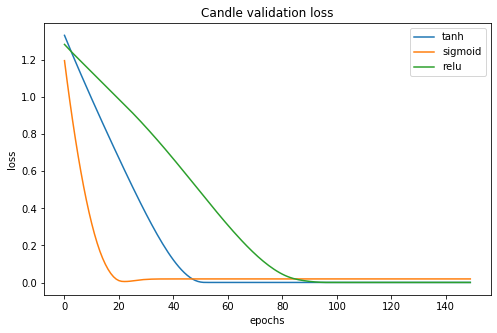

In [14]:
m.plot_validation_loss()

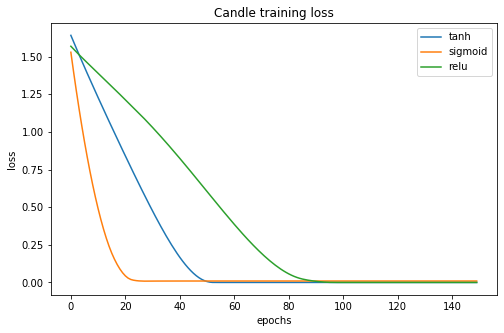

In [15]:
m.plot_train_loss()

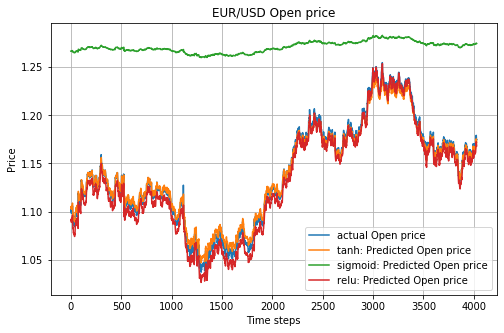

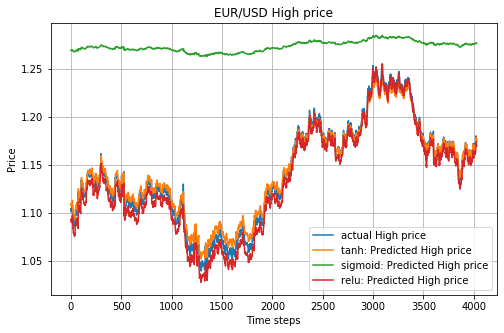

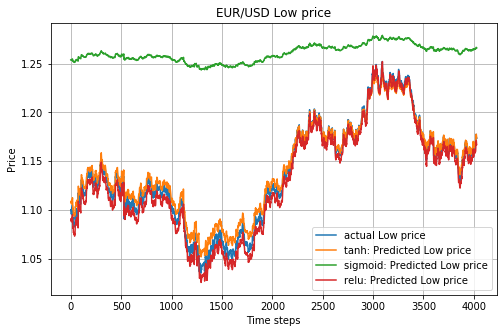

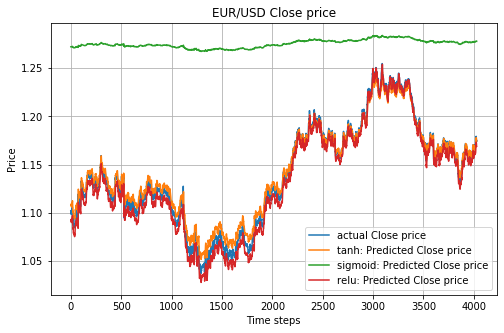

In [16]:
m.plot(name="Open")
m.plot(name="High")
m.plot(name="Low")
m.plot(name="Close")

In [17]:
path = '../Data'
m.save_pred(path)

done writting all..


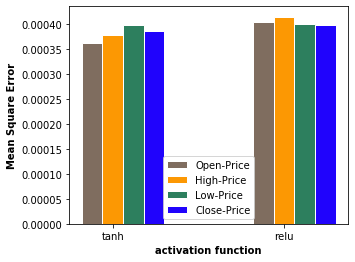

In [18]:
m.plot_error(dictionary, n=2)

In [19]:
# modelFolder = '../Models/'
# cand.save(modelFolder+'fullCandle.h5')